In [1]:
import os, sys
cur_dir = os.getcwd()
basename = os.path.basename(cur_dir)
for _ in range(5):
    if basename != 'OCLog':
        cur_dir = os.path.dirname(cur_dir)
        basename = os.path.basename(cur_dir)
        #print(cur_dir, basename)
    else:
        if cur_dir not in sys.path:
            sys.path.append(cur_dir)
            #print(sys.path)
import os
from openpyxl import Workbook
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import trange, tqdm, tnrange
from oclog.BGL.bgUKCNum import BGLog, get_embedding_layer
from oclog.openset.boundary_loss import euclidean_metric, BoundaryLoss
from oclog.openset.pretraining import LogLineEncoder, LogSeqEncoder, LogClassifier
# from oclog.openset.openset import OpenSet
from oclog.openset.opensetv7 import OpenSet
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import sklearn.metrics as m
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
tf.random.set_seed(1234)
np.random.seed(1234) 

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_tk.pkl
train_0:, 2000, val_0:, 250, test_0:, 250, train_1:, 2000, val_1:, 250, test_1:, 250, train_2:, 2000, val_2:, 250, test_2:, 250, class 5 is added as ukc
ukc_5:, 165
length of train_data - (num_seq_per_cls * num_class)// batch size: 187
length of train_data: 187
length of val_data: 23
vocab_size: 50
187/187 [==============================] - 18s 94ms/step - loss: 0.0672 - accuracy: 0.9793 - precision: 0.9882 - recall: 0.9662 - val_loss: 8.5805e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.63it/s]


epoch: 1/1, train_loss: 2.2392702102661133, F1_train: 0.6653465801632542 F1_val: 0.6644021739130435
[[243   0   0   0   0]
 [  0  11   0   0 235]
 [  0   0 243   0   2]
 [  2   0   0   0 160]
 [  0   0   0   0   0]]
55.47
f1_weighted: 0.5659133546414675, f1_macro: 0.4154812783057983, f1_micro: 0.5546875, f_measure: {'Known': 51.9352, 'Open': 0, 'F1-score': 41.5481}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       243
           1       1.00      0.04      0.09       246
           2       1.00      0.99      1.00       245
           5       0.00      0.00      0.00       162
           7       0.00      0.00      0.00         0

    accuracy                           0.55       896
   macro avg       0.60      0.41      0.42       896
weighted avg       0.82      0.55      0.57       896



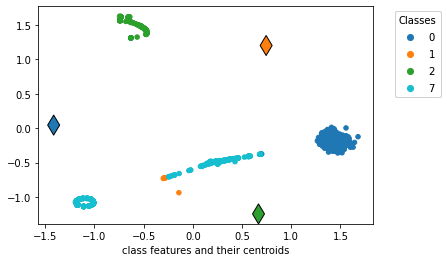

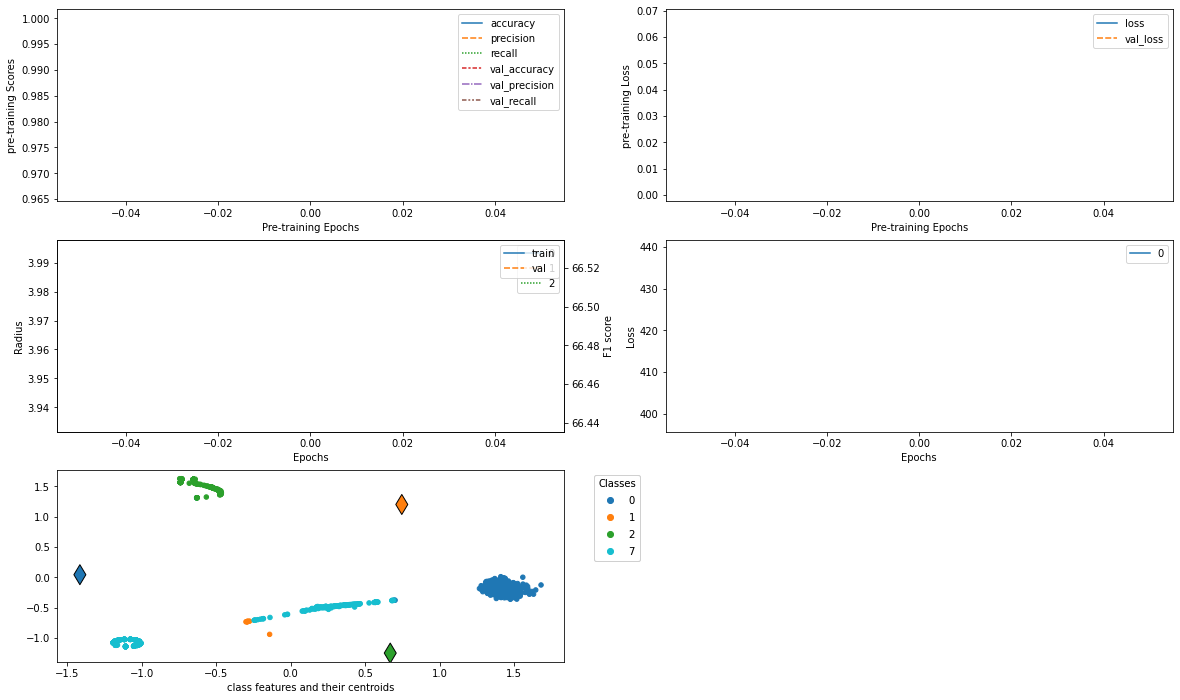

In [2]:
designated_ukc_cls = 5
embedding_size = 12
num_classes= 3
pretrain_epochs = 1
ukc_label=7
bglog = BGLog(save_padded_num_sequences=False, load_from_pkl=True, )
train_test = bglog.get_tensor_train_val_test(ablation=2500, designated_ukc_cls=designated_ukc_cls)
train_data, val_data,  test_data = train_test
print('length of train_data:', len(train_data))
print('length of val_data:',len(val_data))
line_encoder = LogLineEncoder(bglog, chars_in_line=64)
logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
hist = ptmodel.fit(train_data, validation_data=val_data, epochs=pretrain_epochs)    

octrain_epochs = 1
lr_rate = 2.5
wait_patience = 8
optimizer = 'adam'

oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size, ukc_label=ukc_label)
_, _ = oset.train(train_data, data_val=val_data, data_test=test_data, epochs=octrain_epochs, 
                  lr_rate=lr_rate, wait_patience=wait_patience, optimizer=optimizer,
                 pretrain_hist=hist)

In [3]:
# oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size, ukc_label=ukc_label)

[[1991    0    0    3]
 [   0    2    0 1991]
 [   0    0 1975   22]
 [   0    0    0    0]]
66.31
f1_weighted: 0.665513692221743, f1_macro: 0.49892835451123874, f1_micro: 0.6631016042780749, f_measure: {'Known': 66.5238, 'Open': 0, 'F1-score': 49.8928}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1994
           1       1.00      0.00      0.00      1993
           2       1.00      0.99      0.99      1997
           5       0.00      0.00      0.00         0

    accuracy                           0.66      5984
   macro avg       0.75      0.50      0.50      5984
weighted avg       1.00      0.66      0.67      5984



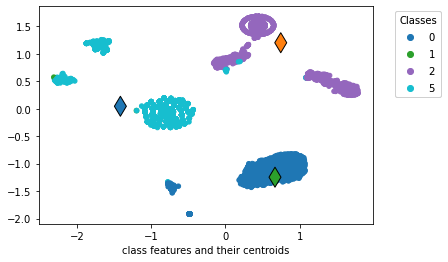

In [15]:
 _, _, f1_weighted, f_measure = oset.evaluate(train_data, ukc_label=designated_ukc_cls, store_features=True)

[[243   0   0   0]
 [  0  10   0 236]
 [  0   0 244   2]
 [  2   0   0 159]]
73.21
f1_weighted: 0.6673788559152296, f1_macro: 0.6599593699523701, f1_micro: 0.7321428571428571, f_measure: {'Known': 68.9982, 'Open': 56.9892, 'F1-score': 65.9959}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       243
           1       1.00      0.04      0.08       246
           2       1.00      0.99      1.00       246
           5       0.40      0.99      0.57       161

    accuracy                           0.73       896
   macro avg       0.85      0.76      0.66       896
weighted avg       0.89      0.73      0.67       896



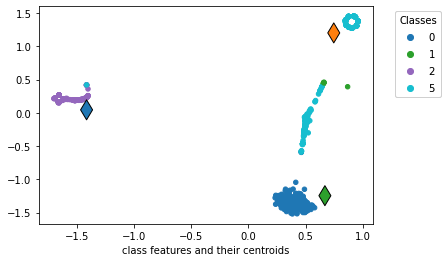

In [14]:
 _, _, f1_weighted, f_measure = oset.evaluate(test_data, ukc_label=designated_ukc_cls, store_features=True, debug=True)

In [6]:
a = np.array(oset.total_features)
print(a.shape)
# a = np.reshape(a, ((a.shape[0] * a.shape[1]), a.shape[2])    )
# print(a.shape)
p = np.array(oset.total_preds)
print(p.shape)
lbl_a = zip(a, p)
lbl_a = np.array(lbl_a)
print(lbl_a.shape)

(896, 12)
(896,)
()


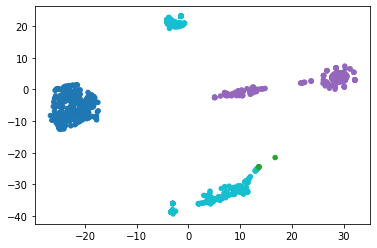

In [7]:
from sklearn.manifold import TSNE
tsne = TSNE()
tout = tsne.fit_transform(a)
# print('tout.shape', tout.shape,  'a',a[0], 'tout', tout[0], 'label', p)
plt.scatter(tout[:, 0], tout[:, -1], c=p, s=20, cmap='tab10')
plt.show()

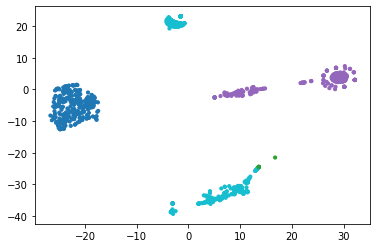

In [8]:
plt.scatter(tout[:, 0], tout[:, -1], c=p, s=10, cmap='tab10')

c: (3, 12)
[-10.0111 129.9697]


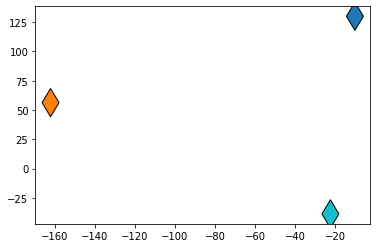

In [9]:
c = oset.centroids.numpy()
print('c:', c.shape)
cout = tsne.fit_transform(c)
print(cout[0])
plt.scatter(cout[:, 0], cout[:, -1], c=[0, 1, 9], s=400, cmap='tab10', marker=r'd', edgecolors= 'k')

In [10]:
# perplexity=50, max_iter=2000, early_exag_coeff=12, stop_lying_iter=1000

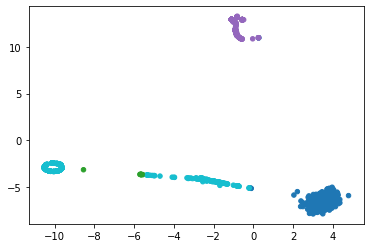

In [11]:
tsne = TSNE(perplexity=200,  )
tout = tsne.fit_transform(a)
# print('tout.shape', tout.shape,  'a',a[0], 'tout', tout[0], 'label', p)
scatter = plt.scatter(tout[:, 0], tout[:, -1], c=p, s=20, cmap='tab10', label=p)
plt.show()

In [12]:
# sns.lmplot(x=tout[:, 0], y=tout[:, -1], data=tout)

NameError: name 'scaled_tout' is not defined

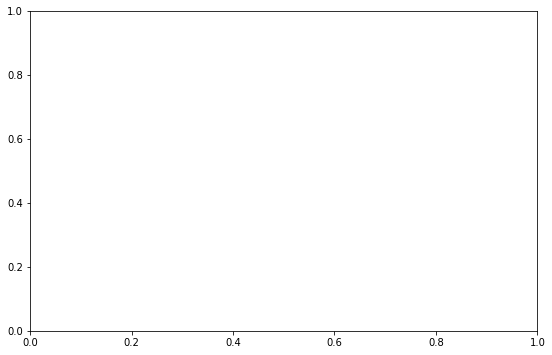

In [13]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(3, 2, 5)
fig5 = ax.scatter(scaled_tout[:, 0], scaled_tout[:, -1], c=p, s=20, cmap='tab10', )
legend1 = ax.legend(*fig5.legend_elements(),
                    loc="upper left", title="Classes",  bbox_to_anchor=(1.05, 1))
ax.add_artist(legend1)
cmap_1 = fig5.get_cmap().colors
ccolor = np.array([cmap_1[i] for i in  range(len(c))])
ax.scatter(scaled_cout[:, 0], scaled_cout[:, -1],  s=200, c=ccolor, cmap='tab10', marker=r'd', edgecolors= 'k')
ax.set_xlabel("class features and their centroids")
plt.show()

In [ ]:
f1 = [0, 1, 0, 0, 0]
f2 = [0, 0, 2, 0, 0]
f3 = [0, 0, 3, 0, 0]
f4 = [0, 0, 4, 0, 0]
b1 = [f1, f2]
b2 = [f2, f3]

a = np.array([b1, b2])
print(a.shape)
print(a)
b = np.reshape(a, (4, 5))
print(b.shape)
print(b)

In [ ]:
len(train_data)